In [1]:
from __future__ import division

from classy import Class
import numpy as np
from math import *
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.integrate import quad # integration
from scipy.integrate import odeint
from scipy import stats
from scipy.misc import derivative
from scipy.interpolate import UnivariateSpline as USpline
from scipy.interpolate import InterpolatedUnivariateSpline as ius 
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline, LinearNDInterpolator, griddata, NearestNDInterpolator, RegularGridInterpolator
from scipy.ndimage.interpolation import map_coordinates
from scipy.special import erfc
import scipy.special as spc # erf, erfc etc etc
from scipy.stats import poisson, norm, chi2, kstest, ks_2samp
from time import time #
from astropy import constants as const
from astropy.io import fits
import multiprocessing
import emcee # MCMCsampler
import corner # triangle plot
from skmonaco import mcquad, mcmiser, mcimport

%matplotlib inline


#### By Nathalia Cibirka <nathcibirka@gmail.com> ####
#### Contributions from Matteo Costanzi and Daniel Gruen ####

In [2]:
c_light = (const.c.to('km/s')).value
G = (const.G.to('km2 Mpc / (M_sun s2)')).value
A_codex = 1e4*(np.pi/180)**2  ### CODEX area in steradians

In [3]:
###### getting the power spectrum and cosmological parameters from Class #######
params = {'output':'mPk mTk', 'z_max_pk': 2., 'P_k_max_1/Mpc': 100., 'h' : 0.70, 'Omega_b': 0.04900, 'Omega_cdm' : 0.237,
            'A_s' : 2.2e-9, 'n_s' : 0.962, 'k_per_decade_for_pk' : 50}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

#sigma8 = 0.82
#print cosmo.sigma8() 

k = np.logspace(-4, 2, 100)
mpk = [cosmo.pk(i, 0) for i in k]  #pk(k, z)
P = USpline(k, mpk, s=0, k=5)

h = cosmo.h()
H0 = cosmo.Hubble(0)
Omegam = cosmo.Omega_m()
Omega_l = 1 - Omegam
Omega_k = 0

rho_c0_mpc = 3 * (H0*c_light)**2 / (8 * np.pi * G)
rhoM0 = cosmo.Omega0_m() * rho_c0_mpc

In [4]:
###### define redshift and width of the z bin #####
z = 0.3
zbin_width = 0.1

###### set mass range ######
logMmin = 13
logMmax = 15.5
n_M = 500
mass_range = np.logspace(logMmin, logMmax, n_M)
lnm = np.log(mass_range)

######### mass to radius #######
m_2_r = lambda m: (3. * m * h**2 / (4. * pi * rhoM0)) ** (1. / 3.)
########## radius to mass ##########
r_2_m = lambda r: (4. / 3.) * pi * rhoM0 * r ** 3

m2r_range = m_2_r(mass_range)
m2r_range_diff = np.diff(m2r_range)

#Wk = np.empty((len(k),len(mass_range)))
#for i in xrange(len(mass_range)): Wk[:,i] = 3*(np.sin(k*m2r_range[i])-k*m2r_range[i]*np.cos(k*m2r_range[i]))/(k*m2r_range[i])**3
    
#sigma2_0 = np.empty(len(mass_range))
#for i in xrange(len(mass_range)): sigma2_0[i] = (np.trapz(P(k)*Wk[:,i]**2*k**3, dx=np.log(k[1]/k[0]))/(2*np.pi**2))

In [5]:
### variance of the linear density field smoothed on a scale R corresponding to mass_range at z=0 ###
def int_sigma2(k, r):
    kr = k * r
    window = (3. / (kr ** 3)) * (np.sin(kr) - kr * np.cos(kr))
    return ((k ** 2) / (2. * pi ** 2)) * P(k) * window ** 2

sigma2_0 = np.array([integrate.quad(int_sigma2, 1e-4, 5, args=r/h, epsrel=1e-5, limit=200)[0] for r in m2r_range])


### growth function provided by Steffen ###
def z_to_a(z):
    return 1./(1+z)

def a_to_z(a):
    return 1./a -1.

w0_fld = -1.
wa_fld = 0.

#linear scaling
def w_de(a):
    result = w0_fld + (1. - a) * wa_fld
    return result

#defined in Linder+Jenkins MNRAS 346, 573-583 (2003)
#solved integral by assuming linear w_de scaling analytically
def x_plus(a):
    aux = 3.0 * wa_fld * (1. - a)
    result = Omegam / (1. - Omegam) * a**(3. * (w0_fld + wa_fld)) * np.exp(aux)
    return result

# growth function D/a from Linder+Jenkins MNRAS 346, 573-583 (2003)
# independent of a at early times: initial conditions g(a_early) = 1, g'(a_early) = 0
# choose a_early ~ 1./30. where Omega_m ~ 1
def g(y, a):
    y0 = y[0]
    y1 = y[1]
    y2 = -(7./2. - 3./2. * w_de(a)/(1+x_plus(a))) * y1 / a - 3./2. * (1-w_de(a))/(1.+x_plus(a)) * y0 / a**2
    return y1, y2

a_array = np.linspace(1./10., 1, 1000)
#a_array = 1./(1+z_array)
init = 1., 0.

# solve for growth
solution = odeint(g, init, a_array)

growspline = USpline(a_array, a_array*solution[:,0]/solution[-1, 0], k=5)
s2 = a_array*solution[:,0]/solution[-1, 0]
growspline1 = lambda a: np.interp(a, a_array, s2)

In [6]:
##### compute Tinker mass function dn/dlnM #####

### mass function parameters for z = 0; table to interpolate tinker2008 params ###
delta_vec = np.log10([ 200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.])
norm_vec = [ 0.186, 0.200, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260 ]
a_vec = [ 1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66 ]
b_vec = [ 2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41 ]
c_vec = [ 1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44 ]

#### interpolation for Tinker parameters ####
normspline = interp1d(delta_vec, norm_vec, kind='cubic')
aspline = interp1d(delta_vec, a_vec, kind='cubic')
bspline = interp1d(delta_vec, b_vec, kind='cubic')
cspline = interp1d(delta_vec, c_vec, kind='cubic')

log_delta_vec = np.log10(np.logspace(delta_vec.min(), delta_vec.max(), 10000))

norm_vec = normspline(log_delta_vec)
a_vec = aspline(log_delta_vec)
b_vec = bspline(log_delta_vec)
c_vec = cspline(log_delta_vec)

norm_interp = lambda log_delta: np.interp(log_delta, log_delta_vec, norm_vec)
a_interp = lambda log_delta: np.interp(log_delta, log_delta_vec, a_vec)
b_interp = lambda log_delta: np.interp(log_delta, log_delta_vec, b_vec)
c_interp = lambda log_delta: np.interp(log_delta, log_delta_vec, c_vec)


def dndlnM(lnM, z):
    
    M = np.exp(lnM)
    
    OmegaM = Omegam*(1.+z)**3 * (H0/cosmo.Hubble(z))**2

    #overdensity \Delta
    Delta = 200.
    Delta_mean = Delta / OmegaM #if critical divide by OmegaM, if mean Delta_mean = Delta


    #Tinker+ 08 mass function parameters for z =! 0
    alpha = 10**(-(0.75 / (np.log10(Delta_mean / 75.))) ** 1.2)
    log_Delta_mean = np.log10(Delta_mean)
    A = lambda x: norm_interp(log_Delta_mean) * (1. + x) ** (-0.14)
    a = lambda x: a_interp(log_Delta_mean) * (1. + x) ** (-0.06)
    b = lambda x: b_interp(log_Delta_mean) * (1. + x) ** (-alpha)

    #Tinker+ 08 f(\sigma)
    f_sigma = lambda s2: A(z) * (((np.sqrt(s2) / b(z)) ** (-a(z))) + 1) * np.exp((-c_interp(log_Delta_mean)) / s2)


    # #variance of the linear density field smoothed on a scale R corresponding to mass_range at redshift z
    sigma2 = ((growspline1(z_to_a(z))) ** 2) * sigma2_0
    sigma2_spline = lambda r: np.interp(r, m2r_range, sigma2)

    sigma = np.sqrt(sigma2)

    # sigma_spline = USpline(m2r_range, sigma, k=3, s=0)
    # d_sigma_spl = sigma_spline.derivative()

    der = np.diff(sigma)/m2r_range_diff
    d_sigma_spl2 = lambda r: np.interp(r, m2r_range[:-1], der)


    #\frac{dln \sigma^{-1}}{dln m} = -1\frac{1}{3}\frac{r}{\sigma}\frac{d \sigma}{dr},
    # where \frac{dln r}{dln m} = 1/3, as m \propto r^3
    dlnsig_dlnm = lambda m: -(1. / 3.) * (m_2_r(m)) / np.sqrt(sigma2_spline(m_2_r(m))) * d_sigma_spl2(m_2_r(m))


    ####### halo abundance ######
    dn_dlnm = (f_sigma(sigma2_spline(m_2_r(M))) * (rhoM0 /(M * h**2)) * dlnsig_dlnm(M)) #* 1/M

    return dn_dlnm 

In [7]:
def dndM(lnM, z):
    
    M = np.exp(lnM)
    
    OmegaM = Omegam*(1.+z)**3 * (H0/cosmo.Hubble(z))**2

    #overdensity \Delta
    Delta = 200.
    Delta_mean = Delta / OmegaM #if critical divide by OmegaM, if mean Delta_mean = Delta


    #Tinker+ 08 mass function parameters for z =! 0
    alpha = 10**(-(0.75 / (np.log10(Delta_mean / 75.))) ** 1.2)
    log_Delta_mean = np.log10(Delta_mean)
    A = lambda x: norm_interp(log_Delta_mean) * (1. + x) ** (-0.14)
    a = lambda x: a_interp(log_Delta_mean) * (1. + x) ** (-0.06)
    b = lambda x: b_interp(log_Delta_mean) * (1. + x) ** (-alpha)

    #Tinker+ 08 f(\sigma)
    f_sigma = lambda s2: A(z) * (((np.sqrt(s2) / b(z)) ** (-a(z))) + 1) * np.exp((-c_interp(log_Delta_mean)) / s2)


    # #variance of the linear density field smoothed on a scale R corresponding to mass_range at redshift z
    sigma2 = ((growspline1(z_to_a(z))) ** 2) * sigma2_0
    sigma2_spline = lambda r: np.interp(r, m2r_range, sigma2)

    sigma = np.sqrt(sigma2)

    # sigma_spline = USpline(m2r_range, sigma, k=3, s=0)
    # d_sigma_spl = sigma_spline.derivative()

    der = np.diff(sigma)/m2r_range_diff
    d_sigma_spl2 = lambda r: np.interp(r, m2r_range[:-1], der)


    #\frac{dln \sigma^{-1}}{dln m} = -1\frac{1}{3}\frac{r}{\sigma}\frac{d \sigma}{dr},
    # where \frac{dln r}{dln m} = 1/3, as m \propto r^3
    dlnsig_dlnm = lambda m: -(1. / 3.) * (m_2_r(m)) / np.sqrt(sigma2_spline(m_2_r(m))) * d_sigma_spl2(m_2_r(m))


    ####### halo abundance ######
    dn_dlnm = (f_sigma(sigma2_spline(m_2_r(M))) * (rhoM0 /(M * h**2)) * dlnsig_dlnm(M)) * 1/M

    return dn_dlnm 

In [8]:
##### Draw clusters from the HMF ######

# integral of the HMF to normalize
normalization_HMF = quad(dndlnM, np.min(lnm),np.max(lnm), args = (z))[0]

# Normalized HMF
def mass_function(ln_m):
    dndm = dndlnM(ln_m, z)/normalization_HMF
    return dndm

# comulative distribution function
def cdf_mf(ln_m):
    cdf_temp = np.vectorize(quad)(mass_function,np.min(lnm),ln_m) 
    return cdf_temp[0]

# define array for interpolation
cdfmf4interp = cdf_mf(lnm)

# inverse of the comulative distribution function
icdf_mf = interp1d(cdfmf4interp,lnm, kind='linear')

# Function to draw masses from the HMF
def mass_function_sample(n):
    return icdf_mf(np.random.random(n))

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [9]:
##### Create mass array for n_clusters = \int^max(M)_min(M) HMF * (comoving volume) #####

### Compute comoving volume ###
z_inf = z - zbin_width
z_sup = z

def f_inv_e(z,Om_m):
    a = 1.0/(1.0 + z)
    return 1./np.sqrt(Om_m/a**3. + (1 - Om_m)) #for Omega_m + Omega_l = 1.0 & w_0=1 & w_a=0

def derivs_com_dis(z, Om_m):
    integ = quad(f_inv_e, 0.0, z, args = (Om_m))
    return (2997.92458)**3.0 * f_inv_e(z, Om_m) * integ[0]**2.0

com_vol = quad(derivs_com_dis, z_inf, z_sup, args=(Omegam))[0] * A_codex # check h**3 factor here

def aux_dM(lnm, z):
    return dndlnM(lnm, z) 

def int_dM(z):
    return quad(aux_dM, np.min(lnm), np.max(lnm), args=(z))[0]

def aux_dz(z, Om_m):
    return  int_dM(z) * derivs_com_dis(z, Om_m) * A_codex

def int_z(Om_m):
    return quad(aux_dz, z_inf, z_sup, args=(Om_m))[0]

Nz = int_z(Omegam)

n_cluster = np.int(np.round(Nz))#np.int(np.round(normalization_HMF * com_vol)) # Number of clusters within a redshift and mass range

mass_catalog = np.exp(mass_function_sample(n_cluster)) # drawn from the HMF


In [10]:
##### Draw n_cluster T^exp from dA/DTexp #####

# Reads effective area table
area_flux = np.loadtxt('area_flux.dat').T
area = area_flux[1]
flux = area_flux[0] 

tmp_matrix = np.zeros(len(flux), dtype = np.dtype([('Texp', np.float), ('dA_dTexp', np.float)]))

tmp_matrix['Texp'] = 4*1.2e-11 / (10**flux)
tmp_matrix['dA_dTexp'] = (area/((flux[-1]-flux[0])/(len(flux)-1))) * (10**flux)/(np.log(10)*4*1.2e-11)

tmp_matrix['dA_dTexp'][tmp_matrix['Texp'] < 5] = 0

dAdT = interp1d(tmp_matrix['Texp'], tmp_matrix['dA_dTexp'], kind='cubic')

normalization_dAdT= quad(dAdT,np.min(tmp_matrix['Texp']),np.max(tmp_matrix['Texp']))[0]

def dAdT_function(Texp):
    dAdTexp = dAdT(Texp)/normalization_dAdT
    return dAdTexp

# comulative distribution function
def cdf_dAdT(Texp):
    cdf_temp = np.vectorize(quad)(dAdT_function, np.min(tmp_matrix['Texp']), Texp)
    return cdf_temp[0]

# define array for interpolation
cdfdAdT4interp = cdf_dAdT(tmp_matrix['Texp'])

# inverse of the comulative distribution function
icdf_dAdT = interp1d(cdfdAdT4interp, tmp_matrix['Texp'], kind='linear')

# Function to draw T^exp from the HMF
def dAdT_sample(n):
    return icdf_dAdT(np.random.random(n))


Texp_catalog = dAdT_sample(n_cluster)

In [11]:
##### Function to convert different definitions of mass (from Hu & kravtsov 2003), original by Matteo Costanzi #####

w_0 = -1

def e(a):
    
    espo = -3 * (1 + w_0)
    e = Omegam / (a**3) + (1 - Omegam - Omega_l) / (a**2) + Omega_l * a**espo
    
    return e

def c_param(m, z):    

    c200m = 10.14 * ((m)/(2e12*(1/h)))**(-0.081) * (1+z)**(-1.01)  # Duffy+ 08 for M200m
    c200c = 5.71 * ((m)/(2e12*(1/h)))**(-0.084) * (1+z)**(-0.47)  # Duffy+ 08 for M200c
    cvir = 9*(1+z)**(-1)*(m/1.5e13)**(-0.13)  # Bullock+01 for Mvirmean
    
    return c200m, c200c, cvir

def xxs(f):
    
    a_one = 0.5116
    a_two = -0.4283
    a_tre = -3.13e-3
    a_four = -3.52e-5
    
    fit_p = a_two + a_tre * np.log(f) + a_four * (np.log(f))**2
    xxs = 1 / np.sqrt(a_one * f**(2*fit_p) + 9/16) + 2*f 
    
    return xxs

def f_1overC(c):
    x = 1/c
    return x**3 * (np.log(1 + c) - 1/(1 + x))


### nswitch=0 the mass_input should be in Delta1 w.r.t. critical density and mass_out in Delta2 w.r.t. mean density
### nswitch=1 the mass_input should be in Delta2 w.r.t. mean density and mass_out in Delta1 w.r.t. critical density
### nswitch=2 mass_input in Delta1 and mass_out in Delta2, both critical
### nswitch=3 mass_input in Delta2 and mass_out in Delta1, both mean

def m_delta(z, m_input, Delta1, Delta2, nswitch):
    
    Delta_1 = Delta1
    Delta_2 = Delta2      #(200m needed by Tinker HMF)
    
    a_scale_f = 1/(1 + z)
    om_mat_a = Omegam * (1 + z)**3/e(a_scale_f) #mean matter density at scale factor a
    icchese = om_mat_a - 1
    Delta_vir = (18 * np.pi**2 + 82 * icchese - 39 * icchese**2)/(1 + icchese)
                 
    c_in = c_param(m_input, z)[0] #first compute c(m_input) to get Mvir(m_input)
    
    if nswitch == (0 or 2):
        Mvir = m_input / ((Delta_1/(Delta_vir*om_mat_a)) * (1/c_in)**3 * (1/xxs(Delta_1 / (Delta_vir*om_mat_a) * f_1overC(c_in)))**3)
    else:
        Mvir = m_input / ((Delta_2/Delta_vir) * (1/c_in)**3 * (1/xxs(Delta_2 / Delta_vir * f_1overC(c_in)))**3)
    
    c_p = c_param(Mvir, z)[2] # use c(Mvir) to get M1(M2) or M2(M1)
    
    x_x = 1/c_p  # 1/c
    f_1suC = x_x**3 * (np.log(1 + c_p) - 1/(1 + x_x))   # f(1/c)
     
    arg01 = Delta_1 / (Delta_vir*om_mat_a) * f_1overC(c_p)
    arg02 = Delta_2 / Delta_vir * f_1overC(c_p)
    arg03 = Delta_2 / (Delta_vir*om_mat_a) * f_1overC(c_p)
    arg04 = Delta_1 / Delta_vir * f_1overC(c_p)
    
    if nswitch == 0:
        m_delta = m_input / (xxs(arg02)/xxs(arg01))**3 * (Delta_2*om_mat_a) / Delta_1
    elif nswitch == 1:
        m_delta = m_input / (xxs(arg01)/xxs(arg02))**3 * Delta_1 / (Delta_2*om_mat_a)
    elif nswitch == 2:
        m_delta = m_input / (xxs(arg03)/xxs(arg01))**3 * Delta_2 / Delta_1
    else:
        m_delta = m_input / (xxs(arg04)/xxs(arg02))**3 * Delta_1 / Delta_2
      
    return m_delta


m_delta_vec = np.vectorize(m_delta, excluded = ['z', 'Delta1', 'Delta2', 'nswitch'])

In [12]:
print m_delta(0.3, 3e14, 200, 200, 1) 

2.32371440958e+14


In [13]:
## Compute photon counts \eta from M, T^exp and z and creates \eta catalog ######

kcorr = fits.open('kcor_new_s2.fits')[0].data  ## load table with k-correction
kcorr = kcorr.T

#mvecinterp = np.linspace(3e13, 5e15, 1000)
#m_delta_arr = ([m_delta(z, m, 500, 200, 1) for m in mvecinterp])
#m_delta200500_interp = USpline(mvecinterp, m_delta_arr, k = 2)

# should check the h and E(z) factors in the M-Lx relation below!!!
def transfM(Texp, m, z):
    
    #for this scaling relation m should be 200c
    #m = m_delta(z, m, 200, 200, 1)
    #mt = m_delta(z, m, 500, 200, 1)

    Omegam = 0.28
    Omega_l = 0.72
    Omega_k = 0.0
    Ez = np.sqrt(Omegam * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_l)
        
    #xlcor = (10 ** (((np.log10(m * Ez) - 13.73) / 0.64) + 42.7)) * Ez   # Leauthaud, old Lx-M
    
    t = (np.log10( m * Ez ) - 13.56) / 1.69 
    # from mass to Lx
    xlcor = (10**(43.48 + 2.63 * (t - 0.48) - 0.15 + 0.07)) * Ez # XXL
    t = 10**t
    
    sigma_lx =  0.46 * (1. - 0.61 * z)
    noise_lx = np.random.normal(0, sigma_lx) # log-normal noise
    xlcor_noise = np.exp(np.log(xlcor) + 0.5 * sigma_lx**2 + noise_lx)  # adds log-normal noise to Lx

    xl = xlcor_noise # or xl = xlcor * (Ez) * (0.7**2)??? Ez or Ez^2 to get obs Lx?
    
    #t = 0.2 + 6 * 10**((np.log10(xl) - 44.45)/2.1) # Alexis asked me to use the Mantz+ 16 M-Lx relation, but they
                                                      # don't give a T-Lx relation, so this one is from Finoguenov+ 07
    #k correction
    riw = ((np.log10(t) + 1.5)/0.05)
    iw = int(riw)

    if iw <= 0: iw = 0
    if iw >= 61:  iw = 60

    rjw = z/0.05 - 1
    jw = int(rjw)

    if jw <= 0: jw = 0
    if jw >= 61: jw = 60

    akcor = kcorr[iw][jw]

    if (0 < iw < 60):
        if (riw > iw):
            akcor = akcor + (riw - iw) * (kcorr[iw+1][jw] - kcorr[iw][jw])
        else:
            akcor = akcor + (riw-iw)*(kcorr[iw-1][jw] - kcorr[iw][jw])

    if (rjw > jw):
        if (jw < 61):
            akcor = akcor + (rjw - jw)*(kcorr[iw][jw+1] - kcorr[iw][jw])
        else:
            if (jw > 1): akcor = akcor + (rjw - jw)*(kcorr[iw][jw-1] - kcorr[iw][jw])

    if akcor > 10: akcor = 10

    vcor = 1 + 0.07/(z - 0.05) #Alexis
    Dl = cosmo.luminosity_distance(z) * (1 + z) 
    Dl = Dl * 3.0857e24

    # apply k and v correction and derive flux from Lx
    fl = xl / (akcor*vcor*4*pi*(Dl)**2)

    etaTrue = (fl / 1.2e-11) * Texp

    return etaTrue


#\eta catalog from the T^exp and Mass mock catalogs 
eta_catalog = np.zeros(len(Texp_catalog))

for i in np.arange(len(Texp_catalog)):
    eta_catalog[i]= transfM(Texp_catalog[i], mass_catalog[i], z)

eta_catalog_ob = np.random.poisson(lam = eta_catalog)  

In [14]:
#### get eta from Lx, Texp and z #####

def transfeta(Lx, Texp, z):

    Omegam = 0.28
    Omega_l = 0.72
    Omega_k = 0.0
    Ez = np.sqrt(Omegam * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_l)
    
    t = 0.2 + 6 * 10**((np.log10(Lx) - 44.45)/2.1) 
                                                      
    #k correction
    riw = ((np.log10(t)+1.5)/0.05)
    iw = int(riw)

    if iw <= 0: iw = 0
    if iw >= 61:  iw = 60

    rjw = z/0.05 - 1
    jw = int(rjw)

    if jw <= 0: jw = 0
    if jw >= 61: jw = 60

    akcor = kcorr[iw][jw]

    if (0 < iw < 60):
        if (riw > iw):
            akcor = akcor + (riw - iw) * (kcorr[iw+1][jw] - kcorr[iw][jw])
        else:
            akcor = akcor + (riw-iw)*(kcorr[iw-1][jw] - kcorr[iw][jw])

    if (rjw > jw):
        if (jw < 61):
            akcor = akcor + (rjw - jw)*(kcorr[iw][jw+1] - kcorr[iw][jw])
        else:
            if (jw > 1): akcor = akcor + (rjw - jw)*(kcorr[iw][jw-1] - kcorr[iw][jw])

    if akcor > 10: akcor = 10

    vcor = 1 + 0.07/(z - 0.05) #Alexis
    xl = Lx #* Ez
    Dl = cosmo.luminosity_distance(z) * (1 + z) 
    Dl = Dl * 3.0857e24

    # apply k and v correction and derive flux from Lx
    fl = xl / (akcor*vcor*4*pi*(Dl)**2)

    etaTrue = (fl / 1.2e-11) * Texp
    
    return etaTrue

In [15]:
##### CODEX probability of detection P(eta^ob, M200c, z) from Alexis's simulations #####

#load matrix, interpolate
x_ = np.linspace(0.1, 0.6, 11)
y_ = np.linspace(13.5, 15.5, 21)
z_ = np.linspace(4, 21, 18)

dataP = np.loadtxt('all_prob.cat')  # gives P for 13.5 < M200c < 15.5, 4 < \eta < 21, 0.1 < z < 0.6
aa = np.reshape(dataP, (11, 21, 18))

my_interp = RegularGridInterpolator((x_,y_,z_), aa)

#m_delta_arr2 = ([m_delta(z, m, 200, 200, 1) for m in mvecinterp])
#m_delta200200_interp = USpline(mvecinterp, m_delta_arr2, k = 3)


def prob_D(etaob, z, log10m):
        
        #log10m = np.log10(m_delta(z, 10**log10m, 200, 200, 1)) #np.log10(m_delta200200_interp(10**log10m))  # Mass_in in 200m and Mass_ou in 200c
        
        if etaob < 4:
            prob = 0
        
        elif etaob >= 21:
            prob = 1  # probability is one for any cluster having \eta > 20
            
        else:
        #be carefull with boundaries, as the matrix provides probabilities only for the given ranges of M200c, z
            if log10m > np.max(y_):
                # print "warning: mass out of the upper interpolation range"
                log10m = np.max(y_) 
            if log10m < np.min(y_):
               # print "warning: mass out of the lower interpolation range"
                log10m = np.min(y_)
            if z > np.max(x_):
                # print "warning: z out of the upper interpolation range"
                z = np.max(x_)
            if z < np.min(x_):
                # print "warning: z out of the lower interpolation range"
                z = np.min(x_)
                
            prob = my_interp([z, log10m, etaob])

        return prob

In [16]:
##### Bin the cluster catalog by M, \eta #####

mass_bins = np.arange(13, 15.6, 0.1)
eta_bins = np.arange(4, 22, 1)  # the \eta CODEX detection threshold is 4
        
mass_eta = np.vstack((mass_catalog, eta_catalog_ob)).T  # cluster catalog with mass and \eta

# counts_bins[mass][\eta]
counts_bins, mbins, ebins = np.histogram2d(np.log10(mass_eta[:,0]), mass_eta[:,1], (mass_bins, eta_bins))
mean_mbins = ([(mbins[i]+mbins[i+1])/2 for i in np.arange(0, len(mbins)-1, 1)])
mean_ebins = ([(ebins[i]+ebins[i+1])/2 for i in np.arange(0, len(ebins)-1, 1)])

In [17]:
##### Draw the cluster catalog from HMF + CODEX selection function based on dA/dTexp and the P(\eta^ob, M, z) #
# using a Bernoulli expermient ######

sampleB = []

for i in np.arange(len(mass_eta)):
    probD = prob_D(mass_eta[i,1], z, log10(mass_eta[i,0]))
    probF = np.random.binomial(1, probD)
    if probF == 1:
        sampleB = np.append(sampleB, mass_eta[i,:])

        
sampleB_codex = np.reshape(sampleB, (int(len(sampleB)/2), 2))     
massB_codex = sampleB_codex[:,0]
etaB_codex = sampleB_codex[:,1]

In [18]:
##### Draw a larger cluster catalog from HMF + CODEX selection function based on dA/dTexp and the P(\eta^ob, M, z) #

# massB_codex_mult = []
# for i in np.arange(10):   
#     samples = []
#     for i in np.arange(len(mass_eta)):
#         probD = prob_D(mass_eta[i,1], z, log10(mass_eta[i,0]))
#         probF = np.random.binomial(1, probD)
#         if probF == 1:
#             samples = np.append(samples, mass_eta[i,:])
  
#     sam = np.reshape(samples, (int(len(samples)/2), 2))
#     mass = sam[:,0]
#     etas = sam[:,1]
#     massB_codex_mult = np.append(massB_codex_mult, mass)

In [19]:
##### estimated lensing masses #####

mlens_sigma = 0.5*1e13*np.ones(len(massB_codex))#0.1*massB_codex # actual scatter is a sum of shape noise and intrinsic variance
mlens = massB_codex + np.random.normal(scale = mlens_sigma, size=len(massB_codex))

In [20]:
##### Lambda-M relation to generate lambda catalog from masses #####

alpha_true = 0.75 # alpha_true =  1/alpha
intr_sigma_lnm_true = 0.1
mean_logM0 = 14.236 # 14.24 for M200c, 14.343 for M200m
logM0 = mean_logM0 - 0.39*(Omegam - 0.3)
pivot_m = 10.**logM0
pivot_lnl = np.log(40.)

## Mock Observable-Lambda relation
def mean_l_mock(M):
    mean_l_mock = 1.0 + mean_l_sat(M)
    return mean_l_mock

def mean_l_sat(M):
    mean_lnl_sat = pivot_lnl + alpha_true * np.log(M/pivot_m)
    return np.exp(mean_lnl_sat)

def sigma_lambda(M):
    return np.sqrt(intr_sigma_lnm_true**2.*(mean_l_mock(M)-1.)**2. + (mean_l_mock(M)-1.))

def mass_to_lambda(mass_catalog):
    lambda_sat_mean = mean_l_sat(mass_catalog) #1st only sat
    sat_noise_sigintr = np.random.normal(0., intr_sigma_lnm_true, size = len(lambda_sat_mean)) # log-normal noise
    lambda_sat0 = np.exp(np.log(lambda_sat_mean) + 0.5*intr_sigma_lnm_true**2. + sat_noise_sigintr)
    lambda_sat = np.random.poisson(lam = lambda_sat0) # Poisson noise
    lambda_sat_mean = 1. + lambda_sat # adding central galaxy
    return lambda_sat0 #lambda_sat_mean

In [21]:
##### Assign a lambda_o to the theoretical/CODEX mass catalog #####

lambda_o = mass_to_lambda(mass_catalog)  # theoretical HMF
lambda_o_codex = mass_to_lambda(massB_codex)  # HMF + CODEX selection
lambda_o_lens_codex = mass_to_lambda(mlens) # I'm not using this anymore

In [22]:
#### apply lambda cut ####
cat = np.vstack((mlens, mlens_sigma, lambda_o_codex)).T
lamcut = (cat[:,2] >= 30)
catag = cat[lamcut]

mlens_lambdacut = catag[:,0]
sigmalens_lambdacut = catag[:,1]
lambdalens_lambdacut = catag[:,2]

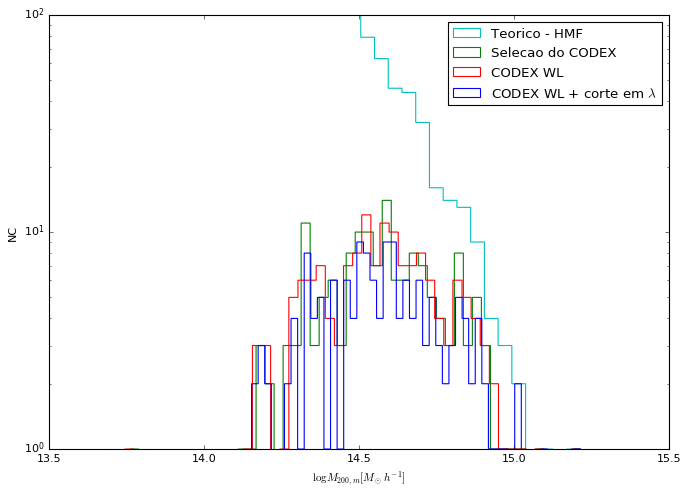

In [23]:
plt.figure(figsize = (10,7))
plt.hist(np.log10(mass_catalog), bins=50, color='c', histtype='step',label='Teorico - HMF')
plt.hist(np.log10(massB_codex), bins = 50, color='g', histtype='step', label = "Selecao do CODEX")
plt.hist(np.log10(mlens), bins = 50, color='r', histtype='step', label = "CODEX WL ")
plt.hist(np.log10(mlens_lambdacut), bins = 50, color='b', histtype='step', label = "CODEX WL + corte em $\lambda$")
plt.yscale("log", nonposx='clip')
plt.legend(loc=1)
plt.xlabel('$\\log M_{200,m} [M_\\odot h^{-1}]$')
plt.ylabel("NC")
plt.xlim(13.5, 15.5)
plt.ylim(1, 1e2)
plt.savefig('massfunc_z45')

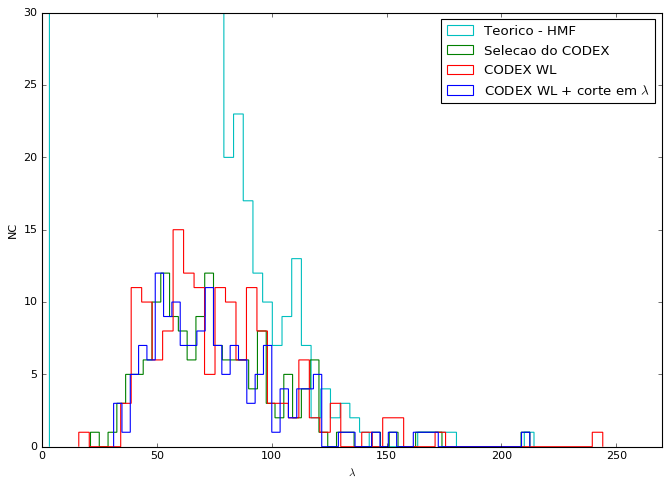

In [24]:
plt.figure(figsize = (10,7))
plt.hist(lambda_o, bins=50, color='c', histtype='step',label='Teorico - HMF')
plt.hist(lambda_o_codex, bins = 50, color='g', histtype='step', label = "Selecao do CODEX")
plt.hist(lambda_o_lens_codex, bins = 50, color='r', histtype='step', label = "CODEX WL")
plt.hist(lambdalens_lambdacut, bins = 50, color='b', histtype='step', label = "CODEX WL + corte em $\lambda$")
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel("NC")
plt.ylim(0,30)
plt.xlim(0, 270)
plt.savefig('richfunc_z45')

P(M | lambda) for theoretical HMF: beta = '1.2456731251', lnM0 = '32.7527434201', std = '0.0238211602957'
P(M | lambda) for CODEX (Mlens): beta = '1.15615460807', lnM0 = '32.8995483262', std = '0.0277573033461'


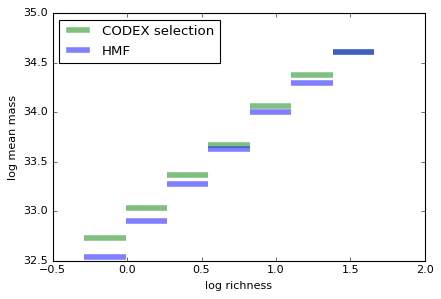

In [25]:
### bin by richness and calculate P(M|lambda) by getting the mean mass and scatter in each bin
lambda_bins = np.logspace(np.log10(30), np.log10(210), 8)

# mean mass in each richness bin
std_logmass_bin, bin_edges, bin_num = stats.binned_statistic(np.log(lambda_o/40), np.log(mass_catalog), 
        bins = np.log(lambda_bins/40), statistic = np.std)

stdCODEX_logmass_bin, bin_edges, bin_num = stats.binned_statistic(np.log(lambdalens_lambdacut/40), 
        np.log(mlens_lambdacut), bins = np.log(lambda_bins/40), statistic = np.std)

mean_logmass_bin, bin_edges, bin_num = stats.binned_statistic(np.log(lambda_o/40), np.log(mass_catalog), 
        bins = np.log(lambda_bins/40), statistic = 'mean')

meanCODEX_logmass_bin, bin_edges, bin_num = stats.binned_statistic(np.log(lambdalens_lambdacut/40), 
        np.log(mlens_lambdacut), bins = np.log(lambda_bins/40), statistic = 'mean')


#print std_logmass_bin, stdCODEX_logmass_bin


plt.hlines(meanCODEX_logmass_bin, bin_edges[:-1], bin_edges[1:], colors='g', lw=5, alpha=0.5, label = 'CODEX selection')
plt.hlines(mean_logmass_bin, bin_edges[:-1], bin_edges[1:], colors='b', lw=5, alpha=0.5, label = 'HMF')
plt.legend(loc=2)
plt.xlabel("log richness")
plt.ylabel("log mean mass")


##### linear fit of P(M | lambda_o) for the theoretical catalog drawn from the HMF (mean_logmass_bin)
# assume that it's given simply by the mean mass in each lambda bin

lam0=40. # pivot lambda, also used in the MCMC fit

mean_bin_lam = ([(bin_edges[i]+bin_edges[i+1])/2 for i in np.arange(len(bin_edges)-1)])
beta_hmf, lnM0_hmf, r_value, p_value, std_err = stats.linregress(mean_bin_lam, mean_logmass_bin)
print "P(M | lambda) for theoretical HMF: beta = '{0}', lnM0 = '{1}', std = '{2}'".format(beta_hmf, lnM0_hmf, std_err)

beta_CDX, lnM0_CDX, r_value_CDX, p_value_CDX, std_err_CDX = stats.linregress(mean_bin_lam, meanCODEX_logmass_bin)
print "P(M | lambda) for CODEX (Mlens): beta = '{0}', lnM0 = '{1}', std = '{2}'".format(beta_CDX, lnM0_CDX, std_err_CDX)

In [26]:
#### functions to enter in P(M | eta > 4)
#### P(Lx | M, z), P(eta_ob | eta(Lx, texp, z)) ####

# get Lx from M, z #
def transfLx(m, z):

    # for this scaling-relation m should be 200c
    m = m_delta(z, m, 200, 200, 1)
    
    Omegam = 0.28
    Omega_l = 0.72
    Omega_k = 0.0
    Ez = np.sqrt(Omegam * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_l)
    
    t = (np.log10( m * Ez ) - 13.56) / 1.69 #t = 10**t
    xl = (10**(43.48 + 2.63 * (t - 0.48) - 0.15 + 0.07)) * Ez
    
    #xl = (10 ** (((np.log10(m * Ez) - 13.73) / 0.64) + 42.7)) * Ez # Leauthaud, old Lx-M

    return xl

# P(Lx | M, z) #
def P_L_M(M, Lx, z):
    sigL =  0.46 * (1. - 0.61 * z)
    P = 1 / (np.sqrt(2 * pi) * Lx * sigL) * np.exp(-(1 / 2) * (np.log(Lx) - np.log(transfLx(M, z)))**2/sigL**2)
    return P

# new scatter in Lx-M including Alexi's covariance, instead of P_L_M 
def P_L_M_cov(Mtrue, Ltrue, z):

    sglx = 0.46 * (1. - 0.61 * z)
    xx1 = np.log(Ltrue) - np.log(transfLx(Mtrue, z))

    rcut = 30
    mcut = 1.58e14 * (pow((rcut/30.),1.3))
    srm = 0.1 if z <= 0.3 else 4.33 * z**4.17
    srmt = np.sqrt((srm**2) + (0.35**2))

    vcov = -0.2 * 0.35/srmt
    r = vcov
    rn = np.sqrt(1 - r*r)
    x = np.log(Mtrue) - np.log(mcut)
    rm = 1.3 * np.sqrt(srm**2 + 0.35**2)
    rsgm = x/rm
    xrc = rsgm/rn

    xxrc = xrc - r * xx1/sglx/rn

    wrc = 1. - 0.5*(erfc(xxrc/np.sqrt(2.0)))

    P = 1. / (np.sqrt(2. * np.pi) * Ltrue * sglx) * np.exp(-(xx1**2)/(2.*(sglx**2)));

    return (P * wrc)
    
# P(eta_ob | eta(Lx, Texp, z)) #

def p_eta_cont(Lx, Texp, etaOb, z):

    etaTrue = transfeta(Lx, Texp, z)

    if etaTrue < 100:
        if etaOb > 150:
            prob = 0.0
        else:
            prob = np.exp(-etaTrue) * etaTrue**etaOb /gamma(etaOb+1)
            #prob = prob)
    else:
        prob = norm.pdf(etaOb, etaTrue, np.sqrt(etaTrue))

    return prob

def transfML(m):
    lambda_sat_mean = mean_l_sat(m) #1st only sat
    sat_noise_sigintr = np.random.normal(0., intr_sigma_lnm_true) # log-normal noise
    lambda_sat0 = np.exp(np.log(lambda_sat_mean) + 0.5*intr_sigma_lnm_true**2. + sat_noise_sigintr)
    lambda_sat = np.random.poisson(lam = lambda_sat0) # Poisson noise
    lambda_sat_mean = 1. + lambda_sat # adding central galaxy
    return lambda_sat0 #lambda_sat_mean

def errorFrich(lnLammin, lnLammax, m, z):
    
    lnLamM = np.log(transfML(m))
    
    if z <= 0.3:
        sigLM = 0.1
    else:
        sigLM = 4.33*(z**4.17)
        
    sigT = np.sqrt((sigLM**2) + (0.35**2))
    
    x1 = (lnLammin - lnLamM) / (np.sqrt(2) * sigT)
    x2 = (lnLammax - lnLamM) / (np.sqrt(2) * sigT)
    result = (1./2.) * (erfc(x1) - erfc(x2))
    
    return result

In [27]:
#### compute P(M | eta > 4) following eqs. 14, 15, 16 from Matteo's likelihood ####
def integrand2(pars, z):
    lnLx, lnTexp, lnetaOb, lnm = pars
    lx = np.exp(lnLx)
    Texp = np.exp(lnTexp)
    etaOb = np.exp(lnetaOb)
    m = np.exp(lnm)
    return prob_D(etaOb, z, np.log10(m)) * Texp * dAdT(Texp) * p_eta_cont(lx, Texp, etaOb, z) * etaOb * P_L_M_cov(m, lx, z) * lx

#integrate int_eta_ob n(eta_ob) over eta_ob, M, Texp, Lx, where n(eta_ob) = int_M P(eta_ob | M)n(M)
#n_etaob_normalization = mcmiser(integrand2, npoints=5e5, xl=[np.log(1e41), np.log(5), np.log(1), np.log(1e13)], xu=[np.log(5e46), np.log(2e3), np.log(250), np.log(3.2e15)], args=[z], nprocs=4)[0]

#print n_etaob_normalization

def integrand1(pars, m, z):
    lnLx, lnTexp, lnetaOb = pars
    lx = np.exp(lnLx)
    Texp = np.exp(lnTexp)
    etaOb = np.exp(lnetaOb)
    lnm = np.log(m)
    return prob_D(etaOb, z, np.log10(m)) * Texp * dAdT(Texp) * p_eta_cont(lx, Texp, etaOb, z) * etaOb * P_L_M_cov(m, lx, z) * lx

#integrate int_eta_ob P(eta_ob | M) n(M) over eta_ob, Texp, Lx and devide by n_etaob_normalization
P_M_etaob = lambda m: mcmiser(integrand1, npoints=5e5, xl=[np.log(1e41), np.log(5), np.log(1)], xu=[np.log(5e46), np.log(2e3), np.log(250)], args=[m, z], nprocs=4)[0]

mass_vec = np.logspace(13, 15.5, 500)
#P_M_etaob_vec = ([P_M_etaob(np.exp(lnm))/n_etaob_normalization for lnm in np.log(mass_vec)])

#np.savetxt('P_M_etaob_30cut.txt', P_M_etaob_vec) 'Pdet_interp2D_lnMz_errorFrich.txt'
pme =  np.loadtxt('P_M_etaob_30cut22.txt')
P_M_etaob_spl = USpline(np.log(mass_vec), pme, s=0, k=2)


lnmass_vec = np.linspace(13.5, 15.5, 21) * np.log(10)
z_vec = np.linspace(0.1, 0.6, 11)

pdet2 = np.loadtxt('Pdet_interp2D_lnMz_errorFrich.txt')#np.loadtxt('Pdet_interp2D_errorFrich_nodndM.txt')  #np.loadtxt('Pdet_interp2D_errorFrich_nodndM.txt')

pdet2_re = np.reshape(pdet2, (21, 11))
pdet2_spl = RectBivariateSpline(lnmass_vec, z_vec, pdet2_re)

#plt.plot(lnmass_vec, pdet2_spl(lnmass_vec, 0.2))#(np.log(mass_vec), P_M_etaob_spl(np.log(mass_vec)))
#plt.xlim(31, 36)

In [28]:
###### implement likelihood int P(K | M) P(M | lambda, MOR) P(M) dM #######
ms_lkl = np.log(np.logspace(13.5, 15.5, 50))

lam0 = 40

beta_start = 1.3
lnM0_start = 32.8
sig_lnM_start = 0.25

### to run for the data use siglens = sig_mlens, change mlens --> np.exp(mlens) and np.log(mlens) --> mlens
def integ_lkl(lnmtrue, beta, lnM0, sig_lnM, sig_mlens, mlens, lam):  # to be integrated over mtrue
    
    #siglens = np.sqrt(np.log(1 + (sig_mlens**2/(np.exp(lnmtrue))**2)))  #sig_mlens
        
    PKM = 1./(np.sqrt(2*np.pi) * sig_mlens) * np.exp(-0.5*((mlens) - np.exp(lnmtrue))**2/(sig_mlens**2))
    
    lnmpred = lnM0 + beta*np.log(lam/lam0)
    std_Mlam = np.sqrt(sig_lnM**2. + beta**2./lam)
    pdf_model = 1./(np.sqrt(2*np.pi) * std_Mlam * np.exp(lnmtrue)) * np.exp(-0.5*(lnmtrue-(lnmpred-0.5*std_Mlam**2.))**2/std_Mlam**2.) ## log-normal

    PM =  pdet2_spl(lnmtrue, 0.35) #P_M_etaob_spl(lnmtrue)    
    
    #if f2(lam) < 0: 
    #    fwl = 1e-10
    #else: 
    #    fwl = f2(lam)
        
    return PKM * pdf_model * PM #* fwl

#integ_lkl_vec = np.vectorize(integ_lkl, excluded=['beta, lnM0, sig_lnM, sig_mlens, mlens, lam'])

intquad = lambda lnmtrue, beta, lnM0, sig_lnM, sig_mlens, mlens, lam: integ_lkl(lnmtrue, beta, lnM0, sig_lnM, sig_mlens, mlens, lam) * np.exp(lnmtrue)

def sum_lnlkl(beta, lnM0, sig_lnM, lam, mlens, sig_mlens):  #integrates integ_lkl over mtrue for each Mlens, lambda
    
    #inte = integ_lkl_vec(ms_lkl, beta, lnM0, sig_lnM, sig_mlens, mlens, lam) * np.exp(ms_lkl)
    #result = np.trapz(inte, x = ms_lkl)  ## 13.1 < ms_lkl[8:] < 15.5
    resquad = quad(intquad, np.min(ms_lkl), np.max(ms_lkl), args = (beta, lnM0, sig_lnM, sig_mlens, mlens, lam))[0]
    
    return resquad

sum_lnlkl_vec = np.vectorize(sum_lnlkl, excluded=['beta, lnM0, sig_lnM'])


def lnlkl(theta, lam, mlens, sig_mlens):
    
    beta, lnM0, sig_lnM = theta
    sumlkl = np.sum(np.log(sum_lnlkl_vec(beta, lnM0, sig_lnM, lam, mlens, sig_mlens))) #sum_lnlkl_vec(beta, lnM0, lam, mlens, sig_mlens) sum the log of sum_lnlkl
    return sumlkl


start = [beta_start, lnM0_start, sig_lnM_start]

t0 = time()
print lnlkl(start, lambdalens_lambdacut, mlens_lambdacut, sigmalens_lambdacut)
t1 = time()
print 'CPU time for one likelihood:', t1-t0

-12363.3603203
CPU time for one likelihood: 0.320019006729


Running MCMC...
Done.
CPU time for loops in Python: 1867.73304391


/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


Mean acceptance fraction: 0.604
MCMC result:
    beta = 1.21003179774 +0.0339412132905 -0.0357054657186
    M0 = 32.8790347252 +0.0313891184334 -0.0292832468948
    sig_lnM = 0.0744607973208 +0.017353977916 -0.0154892009363



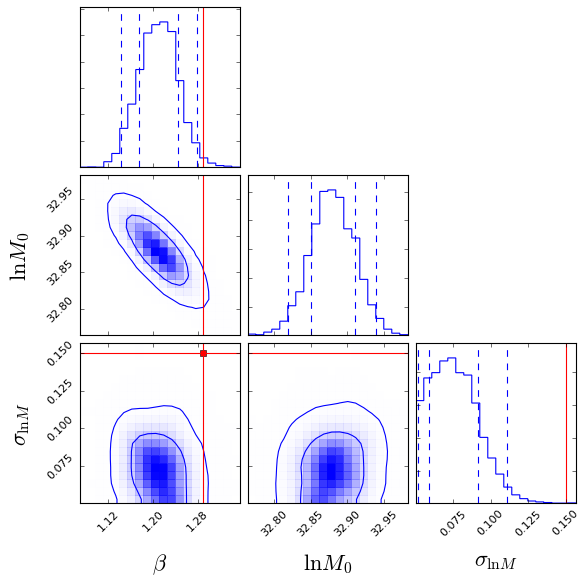

In [34]:
####### find parameters for the Mass - lambda relation
def lnprior(theta):
    
    beta, lnM0, sig_lnM = theta
    
    if (1.0 < beta < 1.5 and 32.2 < lnM0 < 33.7 and 0.05 < sig_lnM < 0.3):
        return 0#-(((sig_lnM) - 0.001)**2/(2*0.1**2)) # - ((lnM0 - 32.9)**2/(2*0.1**2))#   
   
    return -np.inf


def lnprob(theta, lambda_tot, mlens, sig_mlens):
    
    lp = lnprior(theta)
    lnlike = lnlkl(theta, lambda_tot, mlens, sig_mlens)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike #-lnlike_fid


start = [beta_start, lnM0_start, sig_lnM_start]

### here I'm running for the mock, if you want to run for the data change the args in the "sampler" below.
ndim, nwalkers = 3, 10
pool = multiprocessing.Pool()
pos = [start + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lambdalens_lambdacut, mlens_lambdacut, sigmalens_lambdacut), pool= pool)

# Clear and run the production chain.
print("Running MCMC...")
t0 = time()
sampler.run_mcmc(pos, 2000, rstate0=np.random.get_state())
print("Done.")
t1 = time()
print 'CPU time for loops in Python:', t1-t0

burnin = 200
samp = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samp,labels=["$\\beta$","$\\lnM_0$","$\\sigma_{\\ln M}$"],
                   plot_datapoints=False,color='blue',quantiles=(0.025,0.16, 0.84,0.975),levels=(0.68,0.95,),
                    label_kwargs={"fontsize": 20},smooth=(1.0), truths=[1.29,32.73,0.15],truth_color='red')

beta_mcmc, lnM0_mcmc,sig_lnM_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samp, [16, 50, 84],axis=0)))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#logM0_mcmc=np.log10(np.exp(lnM0_mcmc[0]))
print("""MCMC result:
    beta = {0[0]} +{0[1]} -{0[2]}
    M0 = {1[0]} +{1[1]} -{1[2]}
    sig_lnM = {2[0]} +{2[1]} -{2[2]}
""".format(beta_mcmc,lnM0_mcmc,sig_lnM_mcmc))

#fig.savefig('triangle_mock_pivlam60.pdf')

## TESTS 

In [ ]:
### scatter plot: HMF catalog with the mass-richness relation from the linear regression
lam0 = 40

def model(beta, lnM0, lam):
    M0 = np.exp(lnM0)
    return M0*(lam/lam0)**beta

lambda_ = np.linspace(1, 250, 250)


model1 = ([model(beta_hmf, lnM0_hmf, lam) for lam in lambda_])
plt.figure(1)
plt.title('Theoretical HMF mock catalog')
plt.loglog(lambda_o, mass_catalog, 'k.', alpha = 0.5)
plt.loglog(lambda_, model1) 
#plt.xlim(10, 5e2)
plt.ylabel('M$_{\odot}$')
plt.xlabel('$\lambda$')
plt.savefig('linregfit_HMF.jpg')

In [ ]:
### Checking functions used for the mock catalogs with the functions entering the P(CODEX)

In [ ]:
### checking dA/dTexp between mock and likelihood
texp = np.linspace(10, 1e3, 1000)

Texp_samp = ([dAdT(Texp) for Texp in texp])

plt.hist(Texp_catalog, bins = 30, normed = True, alpha = 0.5, label = 'Texp dist. for the mock')
plt.plot(texp, Texp_samp/(np.max(Texp_samp)*300), linewidth = 2, label = 'Texp dist. in the likelihood')
plt.xlim(0, 1500)
plt.legend()

In [ ]:
# checking if the scatter in Lx-M is compatible between the mock catalog and the function P_L_M

sigma_lx =  0.46 * (1. - 0.61 * z)

lx = np.zeros(1000)
for i in np.arange(0, 1000, 1):
    noise_lx = np.random.normal(0, sigma_lx) # log-normal noise
    xlcor_noise = np.exp(np.log(transfLx(5e14, z)) + 0.5 * sigma_lx**2 + noise_lx)  # adds log-normal noise to Lx
    lx[i] = xlcor_noise

lxvec = np.linspace(1e43, 1e45, 1000)

lx2 = ([P_L_M(5e14, Lx, z) for Lx in lxvec])

plt.hist(lx, bins = 30, normed=True, alpha = 0.5, label = 'P(Lx|M,z) for the mock')
plt.plot(lxvec, lx2, linewidth = 2, label = 'P(Lx|M,z) in the likelihood')
plt.xlim(1e43, 5e44)
plt.xlabel("Lx")
plt.ylabel("P(Lx | M, z)")
plt.legend()

In [ ]:
# checking if the poisson distribution used when creating the mock is compatible with the distribution used in P(M | eta>4)

eta1 = np.random.poisson(lam = 30, size=1000)

etaob = np.linspace(1, 60, 1000)

def p_eta_cont2(etaTrue, etaOb):

    if etaTrue < 100:
        if etaOb > 150:
            prob = 0.0
        else:
            prob = np.exp(-etaTrue) * etaTrue**etaOb /gamma(etaOb+1)
            #prob = prob)
    else:
        prob = norm.pdf(etaOb, etaTrue, np.sqrt(etaTrue))

    return prob

eta2 = ([p_eta_cont2(30, etaOb) for etaOb in etaob])
#print eta2
plt.hist(eta1, normed = True, alpha = 0.5, label = 'Poisson dist. etaOb|etaTrue for the mock')
plt.plot(etaob, eta2, linewidth = 2, label = 'Poisson dist. etaOb|etaTrue in the likelihood')
plt.xlabel("$\eta_{ob}$")
plt.ylabel("P(etaOb| etaTrue)")
plt.ylim(0, 0.10)
plt.legend()

In [ ]:
# generate a distribution based on P(M | eta > 4) and compare with the mock data
P_M_etaobM_vec = ([P_M_etaob_spl(lnM) * dndM(lnM, z) for lnM in  np.log(mass_vec)])
P_M_etaobM_spl = USpline(mass_vec, P_M_etaobM_vec, s=0, k=2)

normalization_m = quad(P_M_etaobM_spl, np.min(np.log(mass_vec)), np.max(np.log(mass_vec)))[0]

# Normalized HMF
def p_function(m):
    pm = P_M_etaobM_spl((m))/normalization_m
    return pm

print p_function(33)
# comulative distribution function
def cdf_m(m):
    cdf_temp = np.vectorize(quad)(p_function, np.min(np.log(mass_vec)), np.log(m)) 
    return cdf_temp[0]

print cdf_m(mass_vec[1])
# define array for interpolation
cdfm4interp = cdf_m(mass_vec)

# inverse of the comulative distribution function
icdf_m = interp1d(cdfm4interp, (mass_vec), kind='linear')

# Function to draw masses from the HMF
def mass_f_sample(n):
    return icdf_m(np.random.random(n))
   
#sam_pm = icdf_m(5e14)
sam_pm = mass_f_sample(len(massB_codex))

plt.hist(np.log10((sam_pm)), bins = 50, normed = True, alpha = 0.5, label = 'P(M | $\eta > 4$)')
plt.hist(np.log10(massB_codex), bins = 50, normed = True, alpha = 0.5, label = 'CODEX')
#plt.hist(np.log10(mlens_lambdacut), bins = 50, normed = True, alpha = 0.5, label = 'CODEX $\lambda$ cut')
plt.legend(loc = 2)
#plt.xlim(13.4, 15.6)

print ks_2samp(massB_codex_mult, sam_pm)

In [ ]:
### checking the lambda distribution of the mock vs the pdf model with the linear regression and MCMC results

dic_M = {}
dic_lam = {}

for i in np.arange(30, 350, 10):
    ip = i + 10
    flag_m = np.bitwise_and(lambda_o >= i, lambda_o < ip)
    mb = mass_catalog[flag_m]
    lamb = lambda_o[flag_m]
    #catt = catag[catag[:,2] >= i]
    #cattt = catt[catt[:,2] < ip]
    dic_M['%s' %i] = mb #cattt[:,0]
    dic_lam['%s' %i] = lamb #cattt[:,2]


lam0 = 40
def mean_lnM_model(beta, lnM0, lam): # ln<M|lambda> = lnM0 + beta*ln(lam/lam0)
    return lnM0+beta*np.log(lam/lam0)

def std_dev_model(lam, beta, sig_lnM):
    return np.sqrt(sig_lnM**2.+beta**2./lam)

def pdfmodel(beta, lnM0, sig_lnM, lambda_tot, lnmassa):
    ln_meanM = mean_lnM_model(beta,lnM0,lambda_tot)
    std_dev = std_dev_model(lambda_tot,beta,sig_lnM)
    pdf_model = 1./np.sqrt(2*np.pi)/std_dev/np.exp(lnmassa)*np.exp(-0.5*(lnmassa-(ln_meanM-0.5*std_dev**2.))**2/std_dev**2.)
    return pdf_model

pdfmodel_ = np.vectorize(pdfmodel, excluded=['beta, lnM0, sig_lnM, lambda_tot'])

#P(M | lambda) for theoretical HMF: beta = '1.2878306191', lnM0 = '32.9533640826', std = '0.000600114930482'
#MCMC result (using lambda_o and mass_catalog data, plot attached):
#    beta = 1.0951 +0.0009 -0.0009
#    lnM0 = 32.775 +0.002 -0.002
#    sig_lnM = 0.0102+0.0004 -0.0002

mass_ = np.log(np.logspace(13, 15.5, 200))

fig = plt.figure(figsize=(15,7))
plt.title('P(M | lambda) PDF model 1; red for linreg, green for MCMC')

ax1 = fig.add_subplot(231)
ax1.hist(np.log(dic_M['30']), normed = True, bins = 20, alpha = 0.5)
ax1.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 35, mass_)/1e-15, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax1.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 35, mass_)/1e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(32, 33.5)
plt.text(33, 2.1, '$30 < \lambda < 40$', size = 12)

ax2 = fig.add_subplot(232)
ax2.hist(np.log(dic_M['50']), normed = True, bins = 20, alpha = 0.5)
ax2.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 55, mass_)/1e-15, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax2.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 55, mass_)/1e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(32.5, 34)
plt.text(32.6, 3, '$50 < \lambda < 60$', size = 12)

ax3 = fig.add_subplot(233)
ax3.hist(np.log(dic_M['70']), normed = True, bins = 20, alpha = 0.5)
ax3.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 75, mass_)/1e-15, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax3.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 75, mass_)/1e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.2, 34.4)
plt.text(34, 3.7, '$70 < \lambda < 80$', size = 12)

ax4 = fig.add_subplot(234)
ax4.hist(np.log(dic_M['90']), normed = True, bins = 20, alpha = 0.5)
ax4.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 95, mass_)/1e-16, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax4.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 95, mass_)/1e-16, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.5, 34.5)
plt.text(34.2, 4.5, '$90 < \lambda < 100$', size = 12)

ax5 = fig.add_subplot(235)
ax5.hist(np.log(dic_M['110']), normed = True, bins = 20, alpha = 0.5)
ax5.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 115, mass_)/1e-16, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax5.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 115, mass_)/1e-16, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.7, 34.9)
plt.text(33.77, 10, '$110 < \lambda < 120$', size = 12)

ax6 = fig.add_subplot(236)
ax6.hist(np.log(dic_M['120']), normed = True, bins = 20, alpha = 0.5)
ax6.plot(mass_, pdfmodel_(beta_hmf, lnM0_hmf, 0.1, 125, mass_)/1e-16, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax6.plot(mass_, pdfmodel_(beta_mcmc, lnM0_mcmc, sig_lnM_mcmc, 125, mass_)/1e-16, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.8, 35)
plt.text(33.85, 14, '$120 < \lambda < 130$', size = 12)

In [ ]:
dic_M = {}
dic_lam = {}

for i in np.arange(30, 350, 10):
    ip = i + 10
    flag_m = np.bitwise_and(lambda_o >= i, lambda_o < ip)
    mb = mass_catalog[flag_m]
    lamb = lambda_o[flag_m]
    #catt = catag[catag[:,2] >= i]
    #cattt = catt[catt[:,2] < ip]
    dic_M['%s' %i] = mb #cattt[:,0]
    dic_lam['%s' %i] = lamb #cattt[:,2]


lam0 = 40
def mean_lnM_model(beta, lnM0, lam): # ln<M|lambda> = lnM0 + beta*ln(lam/lam0)
    return lnM0+beta*np.log(lam/lam0)

def std_dev_model(lam, beta, sig_lnM):
    return np.sqrt(sig_lnM**2.+beta**2./lam)

def pdfmodel(beta, lnM0, sig_lnM, lambda_tot, lnmassa):
    ln_meanM = mean_lnM_model(beta,lnM0,lambda_tot)
    pdf_model = 1./np.sqrt(2*np.pi)/sig_lnM/np.exp(lnmassa)*np.exp(-0.5*(lnmassa-ln_meanM)**2/sig_lnM**2.)
    return pdf_model

pdfmodel_ = np.vectorize(pdfmodel, excluded=['beta, lnM0, sig_lnM, lambda_tot'])

#P(M | lambda) for theoretical HMF: beta = '1.2878306191', lnM0 = '32.9533640826', std = '0.000600114930482'
#MCMC result (using lambda_o and mass_catalog data, plot attached):
#    beta = 1.0951 +0.0009 -0.0009
#    lnM0 = 32.775 +0.002 -0.002
#    sig_lnM = 0.0102+0.0004 -0.0002

mass_ = np.log(np.logspace(13, 15.5, 200))

fig = plt.figure(figsize=(15,7))
plt.title('P(M | lambda) PDF model 2; red for linreg, green for MCMC')

ax1 = fig.add_subplot(231)
ax1.hist(np.log(dic_M['30']), normed = True, bins = 20, alpha = 0.5)
ax1.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 35, mass_)/7e-14, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax1.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 35, mass_)/8e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(32, 33.5)
plt.text(32.1, 2.2, '$30 < \lambda < 40$', size = 12)

ax2 = fig.add_subplot(232)
ax2.hist(np.log(dic_M['50']), normed = True, bins = 20, alpha = 0.5)
ax2.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 55, mass_)/2e-14, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax2.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 55, mass_)/4e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(32.5, 34)
plt.text(32.7, 3, '$50 < \lambda < 60$', size = 12)

ax3 = fig.add_subplot(233)
ax3.hist(np.log(dic_M['70']), normed = True, bins = 20, alpha = 0.5)
ax3.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 75, mass_)/2e-14, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax3.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 75, mass_)/2.2e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.2, 34.4)
plt.text(33.3, 3.8, '$70 < \lambda < 80$', size = 12)

ax4 = fig.add_subplot(234)
ax4.hist(np.log(dic_M['90']), normed = True, bins = 20, alpha = 0.5)
ax4.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 95, mass_)/1.6e-14, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax4.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 95, mass_)/1.4e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(33.5, 34.5)
plt.text(33.6, 5, '$90 < \lambda < 100$', size = 12)

ax5 = fig.add_subplot(235)
ax5.hist(np.log(dic_M['110']), normed = True, bins = 20, alpha = 0.5)
ax5.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 115, mass_)/8e-15, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax5.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 115, mass_)/1.1e-15, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(34, 34.9)
plt.text(34.3, 7, '$110 < \lambda < 120$', size = 12)

ax6 = fig.add_subplot(236)
ax6.hist(np.log(dic_M['120']), normed = True, bins = 20, alpha = 0.5)
ax6.plot(mass_, pdfmodel_(1.29, 32.95, 0.01, 125, mass_)/4.5e-15, color='r', linestyle='dashed', linewidth=2.5, label = 'Fit bins')
ax6.plot(mass_, pdfmodel_(1.29, 32.95, 0.13, 125, mass_)/3.5e-16, color='g', linestyle='dashed', linewidth=2.5, label = 'Fit MCMC')
plt.xlim(34, 34.8)
plt.text(34.05, 11, '$120 < \lambda < 130$', size = 12)

#plt.savefig('pdf_PMlam2.jpg')

In [ ]:
#### testing Matteo's suggestion: plot "real" P(M|lambda) hist form data with the P(M|lambda lines) from the relation
# recovery purely from the data and from the MCMC

dic_M = {}
dic_lam = {}

for i in np.arange(30, 350, 10):
    ip = i + 10
    flag_m = np.bitwise_and(lambda_o_codex >= i, lambda_o_codex < ip)
    mb = massB_codex[flag_m]
    lamb = lambda_o_codex[flag_m]
    #catt = catag[catag[:,2] >= i]
    #cattt = catt[catt[:,2] < ip]
    dic_M['%s' %i] = mb #cattt[:,0]
    dic_lam['%s' %i] = lamb #cattt[:,2]
    
    
def Mlam_data(lam):
    return np.exp(lnM0_CDX + beta_CDX * np.log(lam/lam0))

def Mlam_mcmc(lam):
    return np.exp(lnM0_mcmc[0] +  beta_mcmc[0]* np.log(lam/lam0)) 

def Mlam_start(lam):
    return np.exp(lnM0_start +  beta_start * np.log(lam/lam0)) 



fig = plt.figure()

ax1 = fig.add_subplot(231)
ax1.hist(dic_M['30'], normed = True)
plt.axvline(x=Mlam_data(35), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(35), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(35), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(3e14, 7e-15, '$\lambda = 30$')
#plt.legend()

ax2 = fig.add_subplot(232)
ax2.hist(dic_M['40'], normed = True)
plt.axvline(x=Mlam_data(45), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(45), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(45), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(3.5e14, 5e-15, '$\lambda = 40$')
#plt.legend()

ax3 = fig.add_subplot(233)
ax3.hist(dic_M['60'], normed = True)
plt.axvline(x=Mlam_data(65), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(65), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(65), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(6e14, 2.5e-15, '$\lambda = 60$')
plt.xlim(1e14, 8e14)
#plt.legend()

ax4 = fig.add_subplot(234)
ax4.hist(dic_M['80'], normed = True)
plt.axvline(x=Mlam_data(85), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(85), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(85), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(2.4e14, 3.5e-15, '$\lambda = 80$')
#plt.legend()

ax5 = fig.add_subplot(235)
ax5.hist(dic_M['100'], normed = True)
plt.axvline(x=Mlam_data(105), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(105), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(105), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(7.8e14, 4e-15, '$\lambda = 100$')
#plt.legend()

ax6 = fig.add_subplot(236)
ax6.hist(dic_M['120'], normed = True)
plt.axvline(x=Mlam_data(125), color='r', linestyle='--', linewidth=2, label = 'linear regression')
plt.axvline(x=Mlam_mcmc(125), color='g', linestyle='--', linewidth=2, label = 'MCMC')
plt.axvline(x=Mlam_start(125), color='k', linestyle='--', linewidth=2, label = 'start')
plt.text(9.5e14, 3e-15, '$\lambda = 120$')
#plt.legend()

In [ ]:
def PKM(m, mlens, sig_mlens):
    PKM = 1./(np.sqrt(2*np.pi) * sig_mlens * mlens) * np.exp(-(m-np.log(mlens))**2/(2.*sig_mlens**2))
    return PKM

intPKM = lambda mlens, sig_mlens: quad(PKM, np.min(ms_lkl), np.max(ms_lkl), args = (mlens, sig_mlens))[0]

mlens = np.linspace(1e13, 5e15, 1000)
siglens = 0.3*mlens

mu = np.log(3e14/(np.sqrt(1+(siglens**2/3e14**2))))
sig = np.sqrt(np.log(1 + (siglens**2/3e14**2)))

PKM_ = np.vectorize(PKM, excluded = ['m'])
pk = PKM_(mu, mlens, sig)
#plt.hist(mlens_lambdacut, bins = 30, alpha = 0.5, normed = True)
plt.plot(mlens, pk)
plt.xlabel('Mlens')
plt.xlim(5e13, 8e14)

In [ ]:
def PKM(log10mtrue, mlens, sig_mlens):
    mu_mlens = np.log((10**log10mtrue)/(np.sqrt(1+(sig_mlens**2/(10**log10mtrue)**2))))
    siglens = np.sqrt(np.log(1 + (sig_mlens**2/(10**log10mtrue)**2)))
    PKM = 1./(np.sqrt(2*np.pi) * siglens * mlens) * np.exp(-(mu_mlens-np.log(mlens))**2/(2.*siglens**2))
    return PKM
#intPKM = lambda mlens, sigma: quad(PKM, np.min(10**ms_lkl[:]), np.max(10**ms_lkl[:]), args = (mlens, sigma))[0]

PKM_ = np.vectorize(PKM, excluded = ['log10mtrue'])
#pk = PKM_(mlens_lambdacut, sigmalens_lambdacut)
#plt.hist(mlens_lambdacut, bins = 30, alpha = 0.5, normed = True)
#plt.hist(pk, bins = 30, alpha = 0.5, normed = True)
plt.plot(mlens_lambdacut, PKM_(14.2, mlens_lambdacut, sigmalens_lambdacut))
plt.xlabel('Mlens')
#plt.xlim(5e13, 8e14)

In [ ]:
def PKM(m):
    PKM = np.exp(-((m)-mlens_lambdacut[10])**2/(2.*sigmalens_lambdacut[10]**2))
    return PKM

PKM_ = np.vectorize(PKM) 

lam0 = 40
def mean_lnM_model(beta, lnM0, lam): # ln<M|lambda> = lnM0 + beta*ln(lam/lam0)
    return lnM0+beta*np.log(lam/lam0)

def std_dev_model(lam, beta, sig_lnM):
    return np.sqrt(sig_lnM**2.+beta**2./lam)

def pdfmodel(beta, lnM0, sig_lnM, lambda_tot, massa):
    ln_meanM = mean_lnM_model(beta,lnM0,lambda_tot)
    std_dev = std_dev_model(lambda_tot,beta,sig_lnM)
    pdf_model = 1./np.sqrt(2*np.pi)/std_dev/massa*np.exp(-0.5*(np.log(massa)-(ln_meanM-0.5*std_dev**2.))**2/std_dev**2.)
    return pdf_model

pdfmodel_ = np.vectorize(pdfmodel, excluded=['beta, lnM0, sig_lnM, lambda_tot'])
 
p1 = PKM_(10**ms_lkl[8:])
p2 = pdfmodel_(1.25, np.log(10.**14.34846), 0.25, lambdalens_lambdacut[10], 10**ms_lkl[8:])
p3 = P_M_etaobM_interp(10**ms_lkl[8:])
p4 = p1 * p2 * p3

fig = plt.figure(1)

ax1 = fig.add_subplot(221)
ax1.plot(ms_lkl[8:], p1)
plt.axvline(x=np.log10(mlens_lambdacut[10]), color='r', linestyle='--')
#plt.text(13.7, 0.5, 'P(K | M)')
plt.xlim(1e13, 1e15)

ax2 = fig.add_subplot(222)
ax2.plot(ms_lkl[8:], p2)
plt.axvline(x=np.log10(mlens_lambdacut[10]), color='r', linestyle='--')
#plt.text(13.55, 3.5e-15, 'P(M | $\lambda$, MOR)')
plt.xlim(13.5, 15.5)

ax3 = fig.add_subplot(223)
ax3.plot(ms_lkl[8:], p3)
#plt.axvline(x=np.log10(mlens_lambdacut[10]), color='r', linestyle='--')
#plt.text(13.6, 0.5, 'P(M | $\eta > 4$)')
plt.xlim(13.5, 15.5)

ax4 = fig.add_subplot(224)
ax4.plot(ms_lkl[8:], p4)
plt.axvline(x=np.log10(mlens_lambdacut[10]), color='r', linestyle='--')
#plt.text(13.7, 1e-15, 'P(Total)')
plt.xlim(13.5, 15.5)

plt.figure(3)
plt.hist(np.log10(mlens_lambdacut), normed = True, alpha = 0.5)
plt.plot(ms_lkl[8:], p4/5e-12, 'k-', linewidth = 2)
#plt.text(13.8, 1.4, 'M$_{WL, \lambda cut}$ vs P(Total)', size = 15)
plt.xlabel('log10 M$_{\odot}$')
plt.ylabel('#')
plt.xlim(13.7, 15.7)

In [ ]:
alpha_true = 0.75 # alpha_true =  1/alpha
intr_sigma_lnm_true = 0.25
mean_logM0 = 14.343
logM0 = mean_logM0 - 0.39*(Omegam - 0.3)
pivot_m = 10.**logM0
pivot_lnl = np.log(40.)

## Mock Observable-Lambda relation
def mean_l_mock(M):
    mean_l_mock = 1.0 + mean_l_sat(M)
    return mean_l_mock

def mean_l_sat(M):
    mean_lnl_sat = pivot_lnl + alpha_true * np.log(M/pivot_m)
    return np.exp(mean_lnl_sat)

def sigma_lambda(M):
    return np.sqrt(intr_sigma_lnm_true**2.*(mean_l_mock(M)-1.)**2. + (mean_l_mock(M)-1.))

def mass_to_lambda(mass_catalog):
    lambda_sat_mean = mean_l_sat(mass_catalog) #1st only sat
    sat_noise_sigintr = np.random.normal(0., intr_sigma_lnm_true, size = 1) # log-normal noise
    lambda_sat0 = np.exp(np.log(lambda_sat_mean) + 0.5*intr_sigma_lnm_true**2. + sat_noise_sigintr)
    lambda_sat = np.random.poisson(lam = lambda_sat0) # Poisson noise
    lambda_sat_mean = 1. + lambda_sat # adding central galaxy
    return lambda_sat0 #lambda_sat_mean

lam0 = 40
def mean_lnM_model(beta, lnM0, lam): # ln<M|lambda> = lnM0 + beta*ln(lam/lam0)
    return lnM0+beta*np.log(lam/lam0)

def std_dev_model(lam, beta, sig_lnM):
    return np.sqrt(sig_lnM**2.+beta**2./lam)

def pdfmodel(beta, lnM0, sig_lnM, lambda_tot, massa):
    ln_meanM = mean_lnM_model(beta,lnM0,lambda_tot)
    std_dev = std_dev_model(lambda_tot,beta,sig_lnM)
    pdf_model = 1./np.sqrt(2*np.pi)/std_dev/massa*np.exp(-0.5*(np.log(massa)-(ln_meanM-0.5*std_dev**2.))**2/std_dev**2.)
    return pdf_model


lams = np.linspace(1, 150, 100)
lamtest = mass_to_lambda(mass_catalog[100])

pdfmod_ = np.vectorize(pdfmodel, excluded=['beta, lnM0, sig_lnM'])
lampdf = pdfmod_(0.95, 33.4, 0.1, lams, mass_catalog[100])

plt.plot(lams, lampdf)
plt.axvline(x=lamtest, color='r', linestyle='--')
plt.xlim(0, 20)